In [ ]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.max_columns = 500

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

# Кластеризация

Наша задача - предсказать есть диабет у индивида или нет. В качестве таргета - колонка Diabetes. В нем три различных значения: `0`, `1`, `2`. `0` означает, что наблюдаемой здоров, `1` значит, что есть риск диабета, `2` означает наличие диабета. В качестве признаков будем использовать пол, количество лет в США, доход семьи и некоторые показатели, измеренные медицинскими работниками.  

**Задание 1.** В этой части ДЗ попробуем использовать кластеризацию как инструмент при проведении моделирования в задаче классификации

In [ ]:
df = pd.read_csv('datahw21.csv', index_col='Unnamed: 0')

df.head()

Gender  Years_in_US  Family_income  ArmCircum  SaggitalAbdominal  \
0       1          0.0           0.84       35.3               20.6   
1       1          0.0           1.78       34.7               24.4   
2       1          0.0           4.51       33.5               25.6   
3       1          0.0           2.52       21.0               14.9   
4       2          0.0           5.00       25.2               20.7   

   GripStrength  Breast_fed  Diabetes  
0          55.2         2.0       2.0  
1          61.5         2.0       2.0  
2          91.0         2.0       2.0  
3          32.2         2.0       0.0  
4          30.9         2.0       0.0

<Axes: >

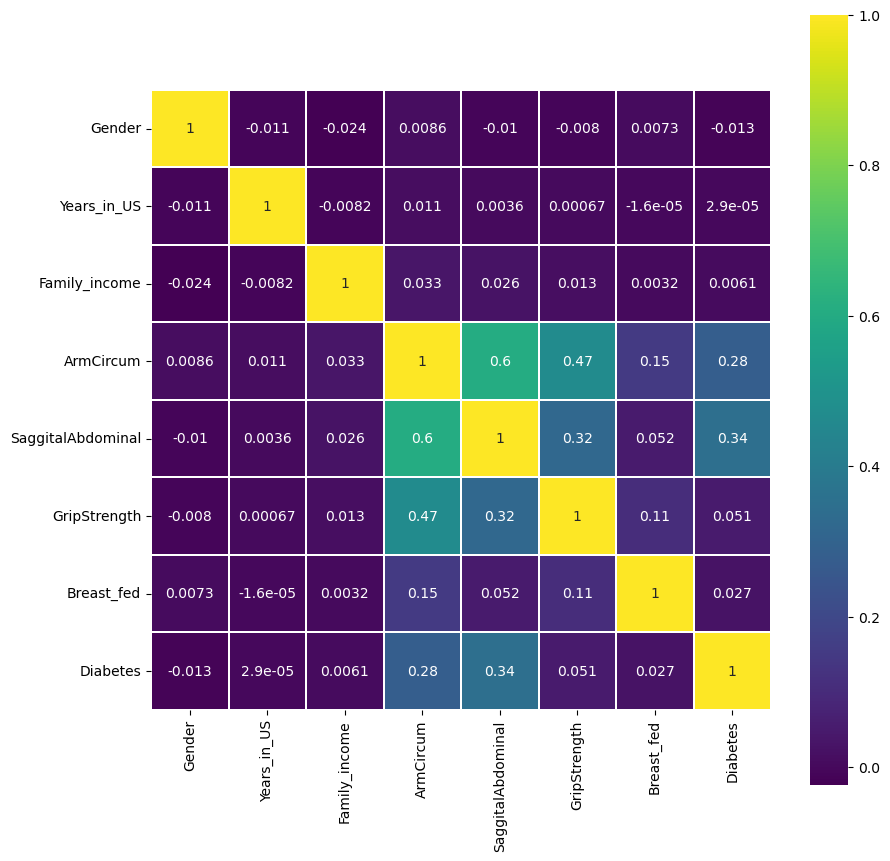

In [ ]:
### Посмотрим как устроены данные
### Изобразим корреляционную матрицу

colormap = plt.cm.viridis
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(), linewidths=0.1, vmax=1.0, square=True, cmap=colormap, annot=True)

In [ ]:
### Разделим выборку на трейн-тест

data = df.drop(['Diabetes'], axis=1)
target = df[['Diabetes']]

X_train, X_test, y_train, y_test = train_test_split(data,
                                                    target,
                                                    test_size=0.25,
                                                    random_state=1)

Для того, чтобы использовать K-means, лучше будет отнормировать данные.

In [ ]:
### Воспользуемся StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

Обучим K-Means с параметрами `n_clusters` = 3, `tol` = 0.0005. Выбор параметров обусловлен тем, что у нас три возможных значения таргета. Но в целом основной подход подбора количества кластеров - по кривой зависимости внутрикластерного и межкластерного расстояний от количества кластеров.

Установите `random_state` = 1

In [ ]:
clusterizer = KMeans(random_state=1, n_clusters=3, tol=0.0005)

clusterizer.fit(X_train_scaled)

KMeans(n_clusters=3, random_state=1, tol=0.0005)

Посчитаем качество на изначальных данных(нормированных). Для этого обучите с дефолтными параметрами `RandomForestClassifier`, `LogisticRegression`, `LinearSVC`. Там, где нужно, установите `random_state` = 1. (1б)

In [ ]:
random_forest = RandomForestClassifier(random_state=1)
random_forest.fit(X_train_scaled, y_train)

l_regression = LogisticRegression(random_state=1)
l_regression.fit(X_train_scaled, y_train)

l_svc = LinearSVC(random_state=1)
l_svc.fit(X_train_scaled, y_train)

LinearSVC(random_state=1)

In [ ]:
random_forest.predict(X_test_scaled)

array([0., 0., 0., ..., 0., 0., 0.])

In [ ]:
print(f"RandomForest {accuracy_score(y_test, random_forest.predict(X_test_scaled)):.3f}")
print(f"LogisticRegression {accuracy_score(y_test, l_regression.predict(X_test_scaled)):.3f}")
print(f"LinearSVC {accuracy_score(y_test,l_svc.predict(X_test_scaled)):.3f}")

RandomForest 0.886
LogisticRegression 0.888
LinearSVC 0.892


Добавьте в признаковое описание номер кластера и посчитайте качество с новым признаком! Стало ли качество хоть сколько-то лучше? (1б)

In [ ]:
X_train_w_cluster = np.hstack((X_train_scaled, clusterizer.predict(X_train_scaled)[:, None]))

X_test_w_cluster = np.hstack((X_test_scaled, clusterizer.predict(X_test_scaled)[:, None]))

In [ ]:
random_forest.fit(X_train_w_cluster, y_train)
l_regression.fit(X_train_w_cluster, y_train)
l_svc.fit(X_train_w_cluster, y_train)

LinearSVC(random_state=1)

In [ ]:
print(f"RandomForest {accuracy_score(y_test, random_forest.predict(X_test_w_cluster)):.3f}")
print(f"LogisticRegression {accuracy_score(y_test, l_regression.predict(X_test_w_cluster)):.3f}")
print(f"LinearSVC {accuracy_score(y_test,l_svc.predict(X_test_w_cluster)):.3f}")

RandomForest 0.888
LogisticRegression 0.888
LinearSVC 0.893


Посчитаем расстояния от объектов до центров кластеров. Для этого воспользуемся методом `transform` обученного класса kmeans.

Обучим и посчитаем метрики исключительно на расстояниях до центра. Убедимся, что такой подход имеет право на существование, если данные позволяют, то качество не сильно должно пострадать. А в каких-то случаях может оказаться даже лучше! Таким образом можно снижать размерность данных. (2б)

In [ ]:
X_train_cluster_distances = clusterizer.transform(X_train_scaled)
X_test_cluster_distances = clusterizer.transform(X_test_scaled)

In [ ]:
random_forest.fit(X_train_cluster_distances, y_train)
l_regression.fit(X_train_cluster_distances, y_train)
l_svc.fit(X_train_cluster_distances, y_train)

LinearSVC(random_state=1)

In [ ]:
print(f"RandomForest {accuracy_score(y_test, random_forest.predict(X_test_cluster_distances)):.3f}")
print(f"LogisticRegression {accuracy_score(y_test, l_regression.predict(X_test_cluster_distances)):.3f}")
print(f"LinearSVC {accuracy_score(y_test,l_svc.predict(X_test_cluster_distances)):.3f}")

RandomForest 0.883
LogisticRegression 0.892
LinearSVC 0.892
